In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased").to('cuda')


def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир! Как житуха, как дела?', model, tokenizer).shape )

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequence

(768,)


In [2]:
import numpy as np
from math import sqrt
text1 = "чайники оченьхорошая штука и сегодня мы вам расскажем почему именно чайники о почему именно чайники оченьхорошая ш чайники оченьхорошая штука и сегодня мы вам расскажем почему именно"
text2 = "сегодня я с женой ходил покупать чайник"
vector1 = np.array(embed_bert_cls(text1, model, tokenizer))
vector2 = np.array(embed_bert_cls(text2, model, tokenizer)) 
print(f"{np.dot(vector1, vector2)/sqrt(np.dot(vector1, vector1)* np.dot(vector2, vector2))}")

0.9042015075683594


In [3]:
t = tokenizer(text1, padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    model_output = model(**{k: v.to(model.device) for k, v in t.items()})

embeddings = model_output.last_hidden_state[:, 0, :]
embeddings1 = model_output.last_hidden_state
print(embeddings.shape)
print(embeddings1.shape)

torch.Size([1, 768])
torch.Size([1, 46, 768])


## rubert-base-cased encode

In [ ]:
import pandas as pd

df = pd.read_json('####')
df.head(1)

In [ ]:
# 15:57 - 

from tqdm import tqdm, tqdm_pandas
tqdm.pandas()

df['st_base'] = None
df.loc[df.site_text.notna(), 'st_base'] = df[df.site_text.notna()]['site_text'].progress_apply(lambda x: np.array(embed_bert_cls(x[:512], model, tokenizer)))

In [ ]:
df.head(1)

In [ ]:
from tqdm import tqdm, tqdm_pandas
tqdm.pandas()

df['at_base'] = None
df.loc[df.ad_text.notna(), 'at_base'] = df[df.ad_text.notna()]['ad_text'].progress_apply(lambda x: np.array(embed_bert_cls(x[:512], model, tokenizer)))
df.head(1)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

import warnings
warnings.filterwarnings('ignore')

df['cos_sim1'] = None
df.loc[df.st_base.notna() & df.at_base.notna(), 'cos_sim1'] = df[df.st_base.notna() & df.at_base.notna()][['st_base', 'at_base']].apply(lambda x: cos_sim([x[0]], [x[1]])[0][0], axis=1)
df.head(1)

In [ ]:
df = df.sort_values(by='ctr')

In [ ]:
to_eval = df[df.cos_sim1.notna()].sort_values(by='ctr')

In [ ]:
import matplotlib.pyplot as plt

y = to_eval.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval.cos_sim1.tolist()) / 25
x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
y = to_eval.ctr.tolist()
x = np.array(to_eval.cos_sim1.tolist())

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

plt.show()

In [ ]:
from sklearn.metrics import ndcg_score #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html

y = to_eval.ctr.tolist()
x = to_eval.cos_sim1.tolist()

true_relevance = np.asarray([y])
scores = np.asarray([x])
res = ndcg_score(true_relevance, scores, k=100)
res

In [ ]:
from copy import deepcopy

random_df = deepcopy(df[df.cos_sim1.notna()])
true_relevance = np.asarray([random_df.ctr.tolist()])

#scores = np.asarray([test_df2.cos_sim.tolist()])
scores = random_df.cos_sim1.to_numpy()
index = np.random.choice(scores.shape[0], 100, replace=False)
scores[:] = 0
scores[index] = 1
scores = scores.reshape((1, -1))

res = ndcg_score(true_relevance, scores, k=100)
res

In [ ]:
t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
t['input_ids'].shape

In [ ]:
for k, v in t.items():
    print(k)
    print(v.shape)
    #print(v[:, :512].shape)
    

In [ ]:
with torch.no_grad():
    model_output = model(**{k: v[:, :512].to(model.device) for k, v in t.items()})

In [ ]:
len(text)

In [ ]:
text = to_eval.site_text.to_list()[0]
embed_bert_cls(text, model, tokenizer)

## rubert-base-cased encode 2

In [ ]:
def embed_bert_cls2(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v[:, :512].to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир! Как житуха, как дела?', model, tokenizer).shape )

In [ ]:
import numpy as np
from math import sqrt
text1 = "чайники оченьхорошая штука и сегодня мы вам расскажем почему именно чайники о почему именно чайники оченьхорошая ш чайники оченьхорошая штука и сегодня мы вам расскажем почему именно"
text2 = "сегодня я с женой ходил покупать чайник"
vector1 = np.array(embed_bert_cls2(text1, model, tokenizer))
vector2 = np.array(embed_bert_cls2(text2, model, tokenizer)) 
print(f"{np.dot(vector1, vector2)/sqrt(np.dot(vector1, vector1)* np.dot(vector2, vector2))}")

In [ ]:
from tqdm import tqdm, tqdm_pandas
tqdm.pandas()

df['st_base2'] = None
df.loc[df.site_text.notna(), 'st_base2'] = df[df.site_text.notna()]['site_text'].progress_apply(lambda x: np.array(embed_bert_cls2(x, model, tokenizer)))

In [ ]:
from tqdm import tqdm, tqdm_pandas
tqdm.pandas()

df['at_base2'] = None
df.loc[df.ad_text.notna(), 'at_base2'] = df[df.ad_text.notna()]['ad_text'].progress_apply(lambda x: np.array(embed_bert_cls2(x, model, tokenizer)))
df.head(1)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

import warnings
warnings.filterwarnings('ignore')

df['cos_sim2'] = None
df.loc[df.st_base2.notna() & df.at_base2.notna(), 'cos_sim2'] = df[df.st_base2.notna() & df.at_base2.notna()][['st_base2', 'at_base2']].apply(lambda x: cos_sim([x[0]], [x[1]])[0][0], axis=1)
df.head(1)

In [ ]:
to_eval2 = df[df.cos_sim2.notna()].sort_values(by='ctr')

In [ ]:
import matplotlib.pyplot as plt

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval2.cos_sim2.tolist()) / 25
x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
from sklearn.metrics import ndcg_score #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html

y = to_eval2.ctr.tolist()
x = to_eval2.cos_sim2.tolist()

true_relevance = np.asarray([y])
scores = np.asarray([x])
res = ndcg_score(true_relevance, scores, k=100)
res

In [ ]:
df.to_json('###')

## rubert-base-cased encode 3

In [ ]:
df.head(1)

In [ ]:
#df.site_text.to_list()[:100]

In [ ]:
t['input_ids'].shape

In [ ]:
def embed_bert_cls2(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v[:, :512].to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир! Как житуха, как дела?', model, tokenizer).shape )

In [ ]:
def embed_bert_cls3(text, model, tokenizer, max_length=512):
    tokens = tokenizer(text, padding=False, truncation=False, return_tensors='pt')
    input_ids = tokens['input_ids'][0]
    attention_mask = tokens['attention_mask'][0]
    
    num_chunks = (len(input_ids) + max_length - 1) // max_length  # вычисляем количество частей
    
    embeddings = []
    with torch.no_grad():
        for i in range(num_chunks):
            chunk_input_ids = input_ids[i * max_length: (i + 1) * max_length].unsqueeze(0).to(model.device)
            chunk_attention_mask = attention_mask[i * max_length: (i + 1) * max_length].unsqueeze(0).to(model.device)
            
            model_output = model(input_ids=chunk_input_ids, attention_mask=chunk_attention_mask)
            chunk_embedding = model_output.last_hidden_state[:, 0, :]
            embeddings.append(chunk_embedding)
    
    # Суммируем все полученные CLS токены и нормализуем
    total_embedding = torch.sum(torch.stack(embeddings), dim=0)
    total_embedding = torch.nn.functional.normalize(total_embedding)
    
    return total_embedding[0].cpu().numpy()

# Пример использования
text = "Твой текст здесь"
embedding = embed_bert_cls3(text, model, tokenizer)
print(embedding.shape)


In [ ]:
len(df.loc[32615].site_text)

In [ ]:
text = df.loc[32615].site_text
embedding = embed_bert_cls3(text, model, tokenizer)
print(embedding.shape)

In [ ]:
import numpy as np
from math import sqrt
text1 = "чайники оченьхорошая штука и сегодня мы вам расскажем почему именно чайники о почему именно чайники оченьхорошая ш чайники оченьхорошая штука и сегодня мы вам расскажем почему именно"
text2 = "сегодня я с женой ходил покупать чайник"
vector1 = np.array(embed_bert_cls3(text1, model, tokenizer))
vector2 = np.array(embed_bert_cls3(text2, model, tokenizer)) 
print(f"{np.dot(vector1, vector2)/sqrt(np.dot(vector1, vector1)* np.dot(vector2, vector2))}")

In [ ]:
import warnings
warnings.filterwarnings('ignore')

df['st_base3'] = None
df.loc[df.site_text.notna(), 'st_base3'] = df[df.site_text.notna()]['site_text'].progress_apply(lambda x: np.array(embed_bert_cls3(x, model, tokenizer)))


df['at_base3'] = None
df.loc[df.ad_text.notna(), 'at_base3'] = df[df.ad_text.notna()]['ad_text'].progress_apply(lambda x: np.array(embed_bert_cls3(x, model, tokenizer)))


df['cos_sim3'] = None
df.loc[df.st_base3.notna() & df.at_base3.notna(), 'cos_sim3'] = df[df.st_base3.notna() & df.at_base3.notna()][['st_base3', 'at_base3']].apply(lambda x: cos_sim([x[0]], [x[1]])[0][0], axis=1)
df.head(1)

In [ ]:
to_eval3 = df[df.cos_sim3.notna()].sort_values(by='ctr')

In [ ]:
import matplotlib.pyplot as plt

y = to_eval3.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval3.cos_sim3.tolist()) / 25
x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
from sklearn.metrics import ndcg_score #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html

y = to_eval3.ctr.tolist()
x = to_eval3.cos_sim3.tolist()

true_relevance = np.asarray([y])
scores = np.asarray([x])
res = ndcg_score(true_relevance, scores, k=100)
res

In [ ]:
df.to_json('###')

## rubert-base-cased encode 3 mean

In [4]:
import pandas as pd

df = pd.read_json('####')

In [ ]:
df['st_base3_mean'] = None

In [12]:
def embed_bert_cls4(text, model, tokenizer, max_length=512):
    tokens = tokenizer(text, padding=False, truncation=False, return_tensors='pt')
    input_ids = tokens['input_ids'][0]
    attention_mask = tokens['attention_mask'][0]
    
    num_chunks = (len(input_ids) + max_length - 1) // max_length  # вычисляем количество частей
    
    embeddings = []
    with torch.no_grad():
        for i in range(num_chunks):
            chunk_input_ids = input_ids[i * max_length: (i + 1) * max_length].unsqueeze(0).to(model.device)
            chunk_attention_mask = attention_mask[i * max_length: (i + 1) * max_length].unsqueeze(0).to(model.device)
            
            model_output = model(input_ids=chunk_input_ids, attention_mask=chunk_attention_mask)
            chunk_embedding = model_output.last_hidden_state[:, 0, :]
            embeddings.append(chunk_embedding)
    
    # Суммируем все полученные CLS токены и нормализуем
    total_embedding = torch.mean(torch.stack(embeddings), dim=0)
    total_embedding = torch.nn.functional.normalize(total_embedding)
    
    return total_embedding[0].cpu().numpy()

# Пример использования
text = "Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесьТвой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь Твой текст здесь"
embedding = embed_bert_cls4(text, model, tokenizer)
print(embedding.shape)


(768,)


In [17]:
text = df.loc[32615].site_text
embedding = embed_bert_cls4(text, model, tokenizer)
print(embedding.shape)

(768,)


In [18]:
import numpy as np
from math import sqrt
text1 = "чайники оченьхорошая штука и сегодня мы вам расскажем почему именно чайники о почему именно чайники оченьхорошая ш чайники оченьхорошая штука и сегодня мы вам расскажем почему именно"
text2 = "сегодня я с женой ходил покупать чайник"
vector1 = np.array(embed_bert_cls4(text1, model, tokenizer))
vector2 = np.array(embed_bert_cls4(text2, model, tokenizer)) 
print(f"{np.dot(vector1, vector2)/sqrt(np.dot(vector1, vector1)* np.dot(vector2, vector2))}")

0.9042015075683594


In [34]:
import pandas as pd
from tqdm import tqdm, tqdm_pandas
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

df['st_base3_mean'] = None
df.loc[df.site_text.notna(), 'st_base3_mean'] = df[df.site_text.notna()]['site_text'].progress_apply(lambda x: np.array(embed_bert_cls4(x, model, tokenizer)))


df['at_base3_mean'] = None
df.loc[df.ad_text.notna(), 'at_base3_mean'] = df[df.ad_text.notna()]['ad_text'].progress_apply(lambda x: np.array(embed_bert_cls4(x, model, tokenizer)))


df['cos_sim3_mean'] = None
df.loc[df.st_base3_mean.notna() & df.at_base3_mean.notna(), 'cos_sim3_mean'] = df[df.st_base3_mean.notna() & df.at_base3_mean.notna()][['st_base3_mean', 'at_base3_mean']].apply(lambda x: cos_sim([x[0]], [x[1]])[0][0], axis=1)
df.head(1)

100%|██████████| 7765/7765 [13:37<00:00,  9.50it/s]


NameError: name 'cos_sim' is not defined

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

df['cos_sim3_mean'] = None
df.loc[df.st_base3_mean.notna() & df.at_base3_mean.notna(), 'cos_sim3_mean'] = df[df.st_base3_mean.notna() & df.at_base3_mean.notna()][['st_base3_mean', 'at_base3_mean']].apply(lambda x: cos_sim([x[0]], [x[1]])[0][0], axis=1)
#df.head(1)

In [36]:
to_eval4 = df[df.cos_sim3.notna()].sort_values(by='ctr')

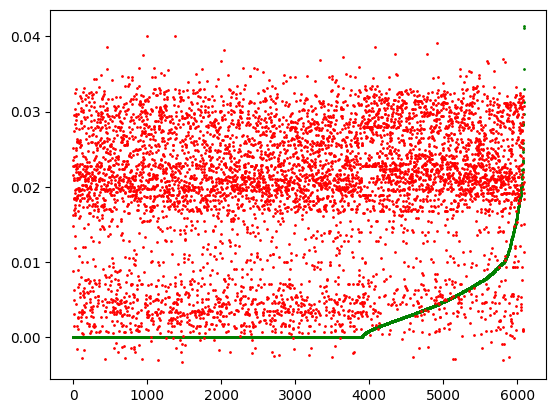

In [37]:
import matplotlib.pyplot as plt

y = to_eval4.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval4.cos_sim3_mean.tolist()) / 25
x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [38]:
df.columns

Index(['ad_id', 'site_id', 'site_url', 'site_text', 'ad_url', 'ad_description',
       'ad_title', 'ad_text', 'clicks_count', 'impression_count', 'ctr',
       'st_base', 'at_base', 'cos_sim1', 'st_base2', 'at_base2', 'cos_sim2',
       'st_base3', 'at_base3', 'cos_sim3', 'ad_desc_tit', 'adt_base',
       'adt_base2', 'adt_base3', 'cos_sim_adt1', 'cos_sim_adt2',
       'cos_sim_adt3', 'st_base3_mean', 'at_base3_mean', 'cos_sim3_mean'],
      dtype='object')

In [39]:
ddf = df[['ad_id', 'site_id', 'st_base3_mean', 'at_base3_mean', 'cos_sim3_mean']]
ddf.head(1)

,ad_id,site_id,st_base3_mean,at_base3_mean,cos_sim3_mean
28494,1769,58,"[-0.009434211, 0.013426143, 0.004026207, 0.007...","[-0.032140974, -0.000507405, 0.09761079, -0.03...",0.087631


In [40]:
ddf.to_json('###')

In [ ]:
text = df.iloc[-1].site_text
tokens = tokenizer(text, padding=False, truncation=False, return_tensors='pt')
input_ids = tokens['input_ids'][0]
readable_tokens = tokenizer.convert_ids_to_tokens(input_ids)
#print(readable_tokens)

## rubert-base-cased encode for (title + description)

In [ ]:
df['ad_desc_tit'] = None
#df.loc[df.site_text.notna(), 'st_base3'] = df[df.site_text.notna()]['site_text'].progress_apply(lambda x: np.array(embed_bert_cls3(x, model, tokenizer)))

df.loc[df.ad_description.notna() & df.ad_title.isna(), 'ad_desc_tit']  = df.loc[df.ad_description.notna() & df.ad_title.isna(), 'ad_description']
df.loc[df.ad_description.isna()  & df.ad_title.notna(), 'ad_desc_tit'] = df.loc[df.ad_description.notna() & df.ad_title.isna(), 'ad_title'] 
df.loc[df.ad_description.notna() & df.ad_title.notna(), 'ad_desc_tit'] = df[df.ad_description.notna() & df.ad_title.notna()][['ad_description', 'ad_title']].apply(lambda x: x[0] + " " + x[1], axis=1)

df.head(2)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

df['adt_base'] = None
df.loc[df.ad_desc_tit.notna(), 'adt_base']  = df[df.ad_desc_tit.notna()]['ad_desc_tit'].progress_apply(lambda x: np.array(embed_bert_cls(x, model, tokenizer)))

df['adt_base2'] = None
df.loc[df.ad_desc_tit.notna(), 'adt_base2'] = df[df.ad_desc_tit.notna()]['ad_desc_tit'].progress_apply(lambda x: np.array(embed_bert_cls2(x, model, tokenizer)))

df['adt_base3'] = None
df.loc[df.ad_desc_tit.notna(), 'adt_base3'] = df[df.ad_desc_tit.notna()]['ad_desc_tit'].progress_apply(lambda x: np.array(embed_bert_cls3(x, model, tokenizer)))


df.head(1)

In [ ]:
df['cos_sim_adt1'] = None
df.loc[df.st_base.notna() & df.adt_base.notna(), 'cos_sim_adt1']   = df[df.st_base.notna()  & df.adt_base.notna()][['st_base', 'adt_base']].apply(lambda x: cos_sim([x[0]], [x[1]])[0][0], axis=1)


df['cos_sim_adt2'] = None
df.loc[df.st_base2.notna() & df.adt_base2.notna(), 'cos_sim_adt2'] = df[df.st_base2.notna() & df.adt_base2.notna()][['st_base2', 'adt_base2']].apply(lambda x: cos_sim([x[0]], [x[1]])[0][0], axis=1)


df['cos_sim_adt3'] = None
df.loc[df.st_base3.notna() & df.adt_base3.notna(), 'cos_sim_adt3'] = df[df.st_base3.notna() & df.adt_base3.notna()][['st_base3', 'adt_base3']].apply(lambda x: cos_sim([x[0]], [x[1]])[0][0], axis=1)

df.head(1)

In [ ]:
to_eval4 = df[df.cos_sim_adt1.notna()].sort_values(by='ctr')

In [ ]:
from sklearn.metrics import ndcg_score #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html

y = to_eval4.ctr.tolist()
x = to_eval4.cos_sim_adt1.tolist()

true_relevance = np.asarray([y])
scores = np.asarray([x])
res = ndcg_score(true_relevance, scores, k=100)
print(res)

x = to_eval4.cos_sim_adt2.tolist()
true_relevance = np.asarray([y])
scores = np.asarray([x])
res = ndcg_score(true_relevance, scores, k=100)
print(res)

x = to_eval4.cos_sim_adt3.tolist()
true_relevance = np.asarray([y])
scores = np.asarray([x])
res = ndcg_score(true_relevance, scores, k=100)
print(res)

In [ ]:
from sklearn.metrics import ndcg_score #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html

y = to_eval4.ctr.tolist()
x = to_eval4.cos_sim_adt1.tolist()

k = len(y)

true_relevance = np.asarray([y])
scores = np.asarray([x])
res = ndcg_score(true_relevance, scores, k=k)
print(res)

x = to_eval4.cos_sim_adt2.tolist()
true_relevance = np.asarray([y])
scores = np.asarray([x])
res = ndcg_score(true_relevance, scores, k=k)
print(res)

x = to_eval4.cos_sim_adt3.tolist()
true_relevance = np.asarray([y])
scores = np.asarray([x])
res = ndcg_score(true_relevance, scores, k=k)
print(res)

In [ ]:
df.to_json('###')

## rubert-base-cased encode for (title + description)

In [ ]:
print(len(df.ad_id.unique()))
print(len(df.site_id.unique()))
print(df.shape[0])
print(len(df.site_id.unique()) * len(df.ad_id.unique()))
print( df.shape[0] / (len(df.site_id.unique()) * len(df.ad_id.unique())) )

In [ ]:
df[['ad_id', 'site_id']].groupby(by='site_id').count()

In [ ]:
a = df[['ad_id', 'site_id']].groupby(by='site_id').count()
a[a['ad_id'] >= 2]

In [ ]:
import pandas as pd

df = pd.read_json('####')

In [ ]:
df.head(1)

In [ ]:
a = df[['ad_id', 'site_id']].groupby(by='site_id').count()
a[a['ad_id'] >= 2]

In [ ]:
df[['ad_id', 'site_id']].groupby(by='site_id').count()


In [ ]:
df[['ad_id', 'site_id']].groupby(by='ad_id').count()

## true nDCG

In [ ]:
import pandas as pd

df = pd.read_json('####')
df.head(1)

In [ ]:
ad_id_list = df.ad_id.unique().tolist()
ad_id_list.sort()

ad_id_dict = {}
for i, v in enumerate(ad_id_list):
    ad_id_dict[v] = i

df['ad_id'] = df.ad_id.apply(lambda x: ad_id_dict[x])

In [ ]:
site_id_list = df.site_id.unique().tolist()
site_id_list.sort()

site_id_dict = {}
for i, v in enumerate(site_id_list):
    site_id_dict[v] = i

df['site_id'] = df.site_id.apply(lambda x: site_id_dict[x])

In [ ]:
import pandas as pd
import numpy as np

unique_ad_ids = df['ad_id'].unique()
unique_site_ids = df['site_id'].unique()

matrix = np.zeros((len(unique_site_ids), len(unique_ad_ids)))

ad_id_to_index = {ad_id: idx for idx, ad_id in enumerate(unique_ad_ids)}
site_id_to_index = {site_id: idx for idx, site_id in enumerate(unique_site_ids)}

for _, row in df.iterrows():
    ad_index = ad_id_to_index[row['ad_id']]
    site_index = site_id_to_index[row['site_id']]
    matrix[site_index, ad_index] = row['ctr']


In [ ]:
df[['site_id', 'st_base']].drop_duplicates(subset=['site_id'])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

max_ad_id = df['ad_id'].max()
max_site_id = df['site_id'].max()

matrix2 = np.zeros((max_site_id + 1, max_ad_id + 1))

for _, row in df.iterrows():
    ad_id = row['ad_id']
    site_id = row['site_id']
    ad_vec = row['adt_base']
    site_vec = row['st_base']
    
    if ad_vec is not None and site_vec is not None:
        similarity = cosine_similarity([ad_vec], [site_vec])[0][0]
        matrix2[site_id, ad_id] = similarity

print(matrix2)


In [ ]:
y = to_eval4.ctr.tolist()
x = to_eval4.cos_sim_adt1.tolist()

k = len(y)

true_relevance = np.asarray(matrix)
scores = np.asarray(matrix2)
res = ndcg_score(true_relevance, scores, k=k)
print(res)

In [ ]:
y = to_eval4.ctr.tolist()
x = to_eval4.cos_sim_adt1.tolist()

k = len(y)

true_relevance = np.asarray(matrix)
scores = np.asarray(matrix2)
res = ndcg_score(true_relevance, scores, k=100)
print(res)

In [ ]:
y = to_eval4.ctr.tolist()
x = to_eval4.cos_sim_adt1.tolist()

k = len(y)

true_relevance = np.asarray(matrix)
scores = np.asarray(matrix2)
res = ndcg_score(true_relevance, scores, k=10)
print(res)

In [ ]:
import numpy as np

def calculate_dcg(true_relevance, scores):
    sorted_indices = np.argsort(scores)[::-1]
    
    sorted_true_relevance = np.array(true_relevance)[sorted_indices]
    
    dcg = 0.0
    for i, rel in enumerate(sorted_true_relevance):
        dcg += (2**rel - 1) / np.log2(i + 2)
    
    return dcg

true_relevance = [5, 1, 0, 0, 10]
scores = [70, 4, 0.3, 0.2, 0.1]

dcg = calculate_dcg(true_relevance, scores)
print(f"DCG: {dcg}")


В sklearn используется линейная шкала, то есть не (2^r ... - 1) а просто r...

## auc roc, pr roc, f1

In [ ]:
df['ctr>0'] = None
df.loc[df.st_base.notna() & df.adt_base.notna(), 'cos_sim_adt1']   = df[df.st_base.notna()  & df.adt_base.notna()][['st_base', 'adt_base']].apply(lambda x: cos_sim([x[0]], [x[1]])[0][0], axis=1)


In [ ]:
df['ctr>0'] = None
df['ctr>0'] = (df['ctr'] > 0).astype(int)
df.head(1)

In [ ]:
df = df.sort_values(by='ctr')

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

y_test = df[df['cos_sim2'].notna()]['ctr>0'].tolist()
y_pred_prob =  df[df['cos_sim2'].notna()]['cos_sim2'].tolist() 

auc_roc = roc_auc_score(y_test, y_pred_prob)

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr = auc(recall, precision)

print(f"AUC-ROC: {auc_roc}")
print(f"AUC-PR: {auc_pr}")


In [ ]:
import matplotlib.pyplot as plt

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval2.cos_sim2.tolist()) / 25
#y[:4000] -= 0.005
#y += np.random.normal(0, 0.5, len(y)) ** 2 + to_eval2.ctr.tolist()
y += np.array(to_eval2.ctr.tolist()) / 30

x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

y_test = df[df['cos_sim2'].notna()]['ctr>0'].tolist()
y_pred_prob =  np.array(df[df['cos_sim2'].notna()]['cos_sim2'].tolist()) + np.array(y_test) / 30

auc_roc = roc_auc_score(y_test, y_pred_prob)

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr = auc(recall, precision)

print(f"AUC-ROC: {auc_roc}")
print(f"AUC-PR: {auc_pr}")

In [ ]:
np.mean(y[:4000])

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

y_test = df[df['cos_sim2'].notna()]['ctr>0'].tolist()
y_probs =  np.array(df[df['cos_sim2'].notna()]['cos_sim2'].tolist()) #+ np.array(y_test) / 30

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

f1_scores = 2 * (precision * recall) / (precision + recall)

best_index = np.argmax(f1_scores[:-2])
best_threshold = thresholds[best_index]

print(f'Лучший порог: {best_threshold}')
print(f'Максимальная F1-мера: {f1_scores[best_index]}')

In [ ]:
print(thresholds.shape)
print(f1_scores.shape)

In [ ]:
import matplotlib.pyplot as plt

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(thresholds, f1_scores[:-1], color='green', s=1)#, marker='o', markersize=1)

plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

f1_scores = 2 * (precision * recall) / (precision + recall)

best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print(f'Лучший порог: {best_threshold}')
print(f'Максимальная F1-мера: {f1_scores[best_index]}')


In [ ]:
print(thresholds.shape)
print(f1_scores.shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

y_test = df[df['cos_sim2'].notna()]['ctr>0'].tolist()
y_probs =  np.array(df[df['cos_sim2'].notna()]['cos_sim2'].tolist()) #+ np.array(y_test) / 30

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1-Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.grid(True)
plt.show()

### ndcg new

In [ ]:
import pandas as pd

df = pd.read_json('####')

In [ ]:
df.head(1)

In [ ]:
a = df[['ad_id', 'site_id']].groupby(by='site_id').count()
unique_site_ids = a[a['ad_id'] >= 2].index.unique().to_list()

In [ ]:
df_eval = df[df.site_id.isin(unique_site_ids)][['ad_id', 'site_id', 'ctr', 'cos_sim_adt1']]
df_eval = df_eval[df_eval.cos_sim_adt1.notna()]
df_eval.head(1)

In [ ]:
import pandas as pd

df_eval2 = df_eval.groupby('site_id').agg({
    'ctr': list,
    'cos_sim_adt1': list
}).reset_index()

df_eval2.columns = ['site_id', 'ctrs', 'cos_sims']

df_eval2


In [ ]:
df_eval2 = df_eval2[df_eval2['ctrs'].apply(len) > 1]
df_eval2

In [ ]:
from sklearn.metrics import ndcg_score
import numpy as np

import warnings
warnings.filterwarnings('ignore')

df_eval2['ndcg'] = df_eval2[['ctrs', 'cos_sims']].apply(lambda x: ndcg_score(np.asarray([x[0]]), np.asarray([x[1]]) ), axis=1)
df_eval2['len']  = df_eval2['ctrs'].apply(len)
df_eval2.head(1)

In [ ]:
import matplotlib.pyplot as plt

y = df_eval2.ndcg.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

plt.show()

In [ ]:
df_eval2.ndcg.to_numpy().mean()

In [ ]:
import seaborn as sns

sns.displot(df_eval2['ndcg'], bins=50) 

plt.title('Распределение длины описания')
plt.xlabel('clicks_count')
plt.ylabel('Плотность')

#plt.xlim((0,20))

plt.show()

In [ ]:
import seaborn as sns

sns.displot(df_eval2[df_eval2.ndcg > 0]['ndcg'], bins=50) 

plt.title('Распределение длины описания')
plt.xlabel('clicks_count')
plt.ylabel('Плотность')

#plt.xlim((0,20))

plt.show()

In [ ]:
df_eval2.sort_values(by='len')

In [ ]:
print(df_eval2[df_eval2.ndcg == 0].shape[0])
print(df_eval2[df_eval2.ndcg == 1].shape[0])

In [ ]:
df_eval2[df_eval2.len != 2].ndcg.to_numpy().mean()

In [ ]:
import pandas as pd

a = df[df.ctr > 0]
a = a[['ad_id', 'site_id']].groupby(by='site_id').count()
unique_site_ids = a[a['ad_id'] >= 2].index.unique().to_list()

df_eval = df[df.site_id.isin(unique_site_ids)][['ad_id', 'site_id', 'ctr', 'cos_sim_adt1']]
df_eval = df_eval[df_eval.cos_sim_adt1.notna()]
df_eval.head(1)


df_eval2 = df_eval.groupby('site_id').agg({
    'ctr': list,
    'cos_sim_adt1': list
}).reset_index()
df_eval2.columns = ['site_id', 'ctrs', 'cos_sims']


df_eval2 = df_eval2[df_eval2['ctrs'].apply(len) > 1]
df_eval2

In [ ]:
from sklearn.metrics import ndcg_score
import numpy as np

import warnings
warnings.filterwarnings('ignore')

df_eval2['ndcg'] = df_eval2[['ctrs', 'cos_sims']].apply(lambda x: ndcg_score(np.asarray([x[0]]), np.asarray([x[1]]) ), axis=1)
df_eval2['len']  = df_eval2['ctrs'].apply(len)
df_eval2.head(1)

In [ ]:
np.asarray([list(range(30))])

In [ ]:
np.array(list(range(30)))

In [ ]:
s = 0
lis = df_eval2.len.to_list()
lis.sort()

for i in lis:
    scores = np.array(list(range(i)))
    np.random.shuffle(scores)
    scores = np.asarray([scores.tolist()])

    true_relevance = np.asarray([list(range(i))])

    s += ndcg_score(true_relevance, scores, k=10)
s / len(df_eval2.len.to_list())

In [ ]:
true_relevance

In [ ]:
scores

In [ ]:
np.logspace(-5.0, 0.0, num=10)

In [ ]:
s = 0
lis = df_eval2.len.to_list()
lis.sort()

for i in lis:
    scores = np.logspace(-10.0, 0.0, num=i)
    np.random.shuffle(scores)
    scores = np.asarray([scores.tolist()])

    true_relevance = np.asarray([np.logspace(-10.0, 0.0, num=i).tolist()])

    s += ndcg_score(true_relevance, scores, k=10)
s / len(df_eval2.len.to_list())

In [ ]:
df_eval2.sort_values(by='len')

In [ ]:
import matplotlib.pyplot as plt

to_eval2 = df[(df.site_id == 11) & (df.cos_sim_adt1.notna())][['ctr', 'cos_sim_adt1']]

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval2.cos_sim_adt1.tolist()) / 25
#y[:4000] -= 0.005
#y += np.random.normal(0, 0.5, len(y)) ** 2 + to_eval2.ctr.tolist()
#y += np.array(to_eval2.ctr.tolist()) / 30

x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

to_eval2 = df[(df.site_id == 13) & (df.cos_sim_adt1.notna())][['ctr', 'cos_sim_adt1']]

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval2.cos_sim_adt1.tolist()) / 25

x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

to_eval2 = df[(df.site_id == 241) & (df.cos_sim_adt1.notna())][['ctr', 'cos_sim_adt1']]

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval2.cos_sim_adt1.tolist()) / 25

x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

to_eval2 = df[(df.site_id == 12) & (df.cos_sim_adt1.notna())][['ctr', 'cos_sim_adt1']]

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval2.cos_sim_adt1.tolist()) / 25

x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

to_eval2 = df[(df.site_id == 138) & (df.cos_sim_adt1.notna())][['ctr', 'cos_sim_adt1']]

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval2.cos_sim_adt1.tolist()) / 25

x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

to_eval2 = df[(df.site_id == 317) & (df.cos_sim_adt1.notna())][['ctr', 'cos_sim_adt1']]

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval2.cos_sim_adt1.tolist()) / 25

x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

to_eval2 = df[(df.site_id == 728) & (df.cos_sim_adt1.notna())][['ctr', 'cos_sim_adt1']]

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval2.cos_sim_adt1.tolist()) / 25

x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

to_eval2 = df[(df.site_id == 829) & (df.cos_sim_adt1.notna())][['ctr', 'cos_sim_adt1']]

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval2.cos_sim_adt1.tolist()) / 25

x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
df_eval2.sort_values(by="len")

In [ ]:
df_eval2[df_eval2.ndcg > 0.8].sort_values(by="len")

In [ ]:
for i in range(2, 188):
    print(f">={i}:\t", df_eval2[df_eval2.len >= i].ndcg.to_numpy().mean())

In [ ]:
df_eval2[df_eval2.len  2].sort_values(by="ndcg")

In [ ]:
import matplotlib.pyplot as plt

to_eval2 = df[(df.site_id == 11) & (df.cos_sim_adt1.notna())][['ctr', 'cos_sim_adt1']]
to_eval2 = to_eval2.sort_values(by='cos_sim_adt1')

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval2.cos_sim_adt1.tolist()) / 25
#y[:4000] -= 0.005
#y += np.random.normal(0, 0.5, len(y)) ** 2 + to_eval2.ctr.tolist()
#y += np.array(to_eval2.ctr.tolist()) / 30

x = list(range(len(y)))

plt.scatter(x, y, color='red', s=1)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

to_eval2 = df[(df.site_id == 11) & (df.cos_sim_adt1.notna())][['ctr', 'cos_sim_adt1']]
to_eval2 = to_eval2.sort_values(by='cos_sim_adt1')

y = to_eval2.ctr.tolist()
x = list(range(len(y)))

plt.scatter(x, y, color='green', s=1)#, marker='o', markersize=1)

y = np.array(to_eval2.cos_sim_adt1.tolist()) / 25
#y[:4000] -= 0.005
#y += np.random.normal(0, 0.5, len(y)) ** 2 + to_eval2.ctr.tolist()
#y += np.array(to_eval2.ctr.tolist()) / 30

x = list(range(len(y)))
plt.scatter(x, y, color='red', s=1)



y = to_eval2.ctr.tolist()
window_size = 20
window = np.ones(window_size) / window_size
moving_average = np.convolve(y, window, mode='valid')

x = list(range(19, len(y)))
plt.scatter(x, moving_average, color='blue', s=1)#, marker='o', markersize=1)


plt.show()

In [ ]:
y = to_eval2.ctr.tolist()
window_size = 20
window = np.ones(window_size) / window_size
moving_average = np.convolve(y, window, mode='valid')

x = list(range(19, len(y)))

print(len(x))
print(len(y))
print(len(moving_average))